In [1]:
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (6, 6)

import math
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.stats

from astropy.io import fits
import os.path

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/PIL/Image.py:85: RuntimeWarning: The _imaging extension was built for another  version of Pillow or PIL
  warnings.warn(str(v), RuntimeWarning)
/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/astropy/utils/introspection.py:153: UserWarning: Module argparse was already imported from /Users/jdecock/anaconda/envs/cta/lib/python3.5/argparse.py, but /Users/jdecock/.local/lib/python3.5/site-packages/argparse-1.1-py3.5.egg is being added to sys.path
  from pkg_resources import parse_version



## Options

In [2]:
!mr_filter -h

Usage: mr_filter options in_image out_image

   where options =  
         [-f type_of_filtering]
              1: Multiresolution Hard K-Sigma Thresholding 
              2: Multiresolution Soft K-Sigma Thresholding 
              3: Iterative Multiresolution Thresholding 
              4: Adjoint operator applied to the multiresolution support  
              5: Bivariate Shrinkage 
              6: Multiresolution Wiener Filtering 
              7: Total Variation + Wavelet Constraint 
              8: Wavelet Constraint Iterative Methods 
              9: Median Absolute Deviation (MAD) Hard Thesholding 
              10: Median Absolute Deviation (MAD) Soft Thesholding 
              default is Multiresolution Hard K-Sigma Thresholding.

         [-C Coef_Detection_Method]
              1: K-SigmaNoise Threshold
              2: False Discovery Rate (FDR) Theshold
              3: Universal Threshold
              4: SURE Threshold
              5: Multiscale SURE Threshold
      

## Tool functions

### Afficher les informations d'un fichier fits

In [3]:
# %load /Users/jdecock/git/pub/jdhp/snippets/python/astropy/fits/print_infos.py
def fits_info(file_path):
    hdu_list = fits.open(file_path)
    hdu_list.info()
    hdu_list.close()

### Créer un fichier fits

In [4]:
# %load /Users/jdecock/git/pub/jdhp/snippets/python/astropy/fits/create_a_2d_fits_image_v2.py
def data_to_fits(img, file_path):
    hdu = fits.PrimaryHDU(img)
    hdu.writeto(file_path, clobber=True)

### Lire un fichier fits

In [5]:
def fits_to_data(file_path):
    hdu_list = fits.open(file_path) # Open the FITS file
    data = hdu_list[0].data
    hdu_list.close()                # Close the FITS file
    return data

### Charger un fichier fits mrfilter

In [6]:
def read_mr_file(file_path):
    hdu_list = fits.open(file_path) # Open the FITS file
    data = hdu_list[0].data
    hdu_list.close()                # Close the FITS file
    return data

### Plot

In [7]:
def plot(data, title="", log=False):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.set_title(title)
    
    if log:
        # See http://matplotlib.org/examples/pylab_examples/pcolor_log.html
        #     http://stackoverflow.com/questions/2546475/how-can-i-draw-a-log-normalized-imshow-plot-with-a-colorbar-representing-the-raw
        #im = ax1.pcolor(x, y, image_array, norm=LogNorm(vmin=0.01, vmax=image_array.max()), cmap=self.color_map)  # TODO: "vmin=0.01" is an arbitrary choice...
        im = ax1.imshow(data, interpolation='nearest', origin='lower', norm=LogNorm(vmin=0.01, vmax=data.max()), cmap="gnuplot2")   # cmap=cm.inferno and cmap="inferno" are both valid
    else:
        im = ax1.imshow(data, interpolation='nearest', origin='lower', cmap="gnuplot2")   # cmap=cm.inferno and cmap="inferno" are both valid
        #im = ax1.pcolor(x, y, image_array, cmap=self.color_map, vmin=z_min, vmax=z_max)

    plt.colorbar(im, ax=ax1)  # draw the colorbar
    
    #ax2 = fig.add_subplot(212)
    #ax2.hist(data)
    
    plt.show()

## Experiment

### Make data

In [8]:
size = 400

x = np.linspace(.0, np.pi, size)
y = np.linspace(.0, np.pi, size)
X, Y = np.meshgrid(x, y)

Z = np.sin(X*4.) * np.sin(Y*4.) + 1.

#Zmask = np.ones(Zn.shape, dtype=np.bool)
#border_size = int(size / 4)
#Zmask[border_size:2*border_size,border_size:2*border_size] = False
#Z[Zmask] = 0

Zn = Z + np.random.uniform(low=0., high=2., size=Z.shape)

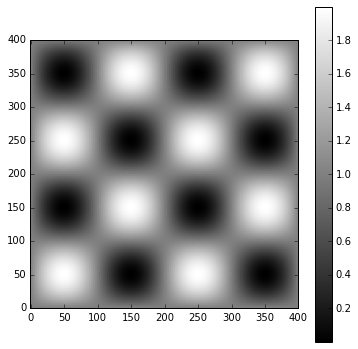

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(Z, interpolation='nearest', origin='lower', cmap="gray") # gnuplot2
plt.colorbar(im, ax=ax)  # draw the colorbar

plt.show()

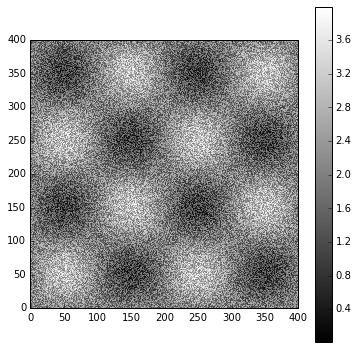

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(Zn, interpolation='nearest', origin='lower', cmap="gray") # gnuplot2
plt.colorbar(im, ax=ax)  # draw the colorbar

plt.show()

In [11]:
Zmask = np.zeros(Zn.shape, dtype=np.bool)

border_size = int(size / 4)
Zmask[:border_size,:border_size] = True
Zmask[-border_size:,-border_size:] = True
Zmask[:border_size,-border_size:] = True
Zmask[-border_size:,:border_size] = True

In [12]:
Znc = Zn.copy()
Znc[Zmask] = 0

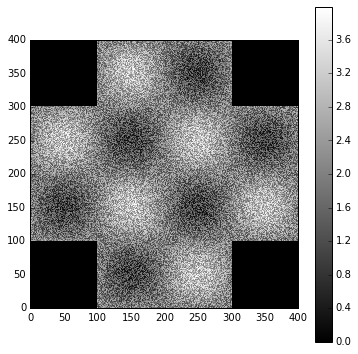

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.imshow(Znc, interpolation='nearest', origin='lower', cmap="gray") # gnuplot2
plt.colorbar(im, ax=ax)  # draw the colorbar

plt.show()

### Make a fits files for mr_filter

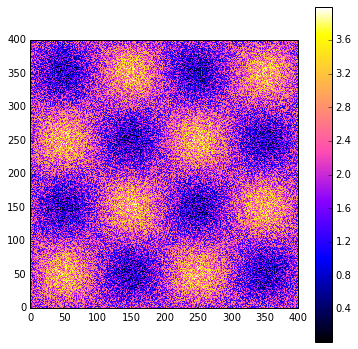

In [14]:
data_to_fits(Zn, "zn.fits")
plot(fits_to_data("zn.fits"))

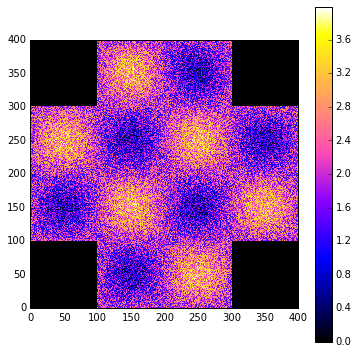

In [15]:
data_to_fits(Znc, "znc.fits")
plot(fits_to_data("znc.fits"))

### Reference

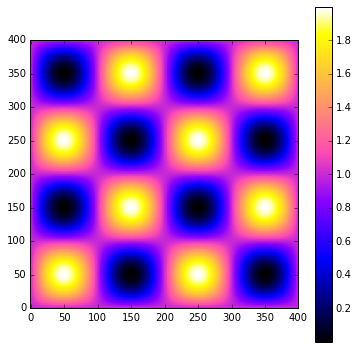

In [16]:
plot(Z)

### Call mr_filter

Filename: out.mr
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      10   (400, 400)   float32   


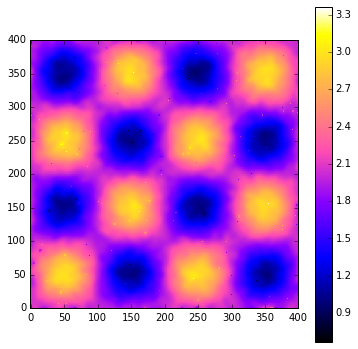

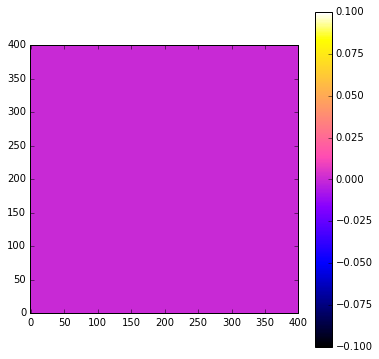

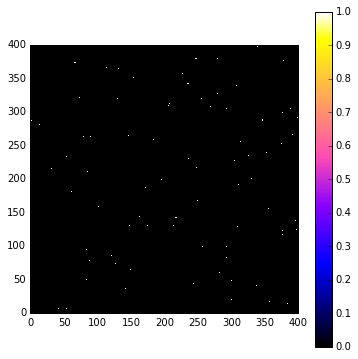

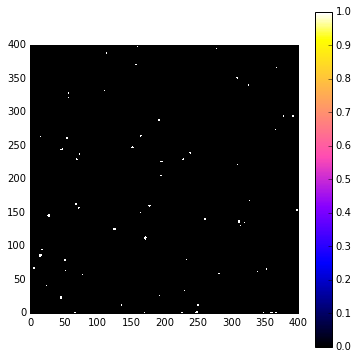

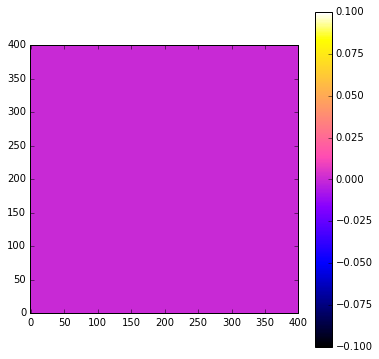

In [17]:
!mr_filter -w planes.mr -n4 zn.fits out.mr

fits_info("out.mr")
plot(read_mr_file("out.mr"))

plot(read_mr_file("planes.mr")[0])
plot(read_mr_file("planes.mr")[1])
plot(read_mr_file("planes.mr")[2])
plot(read_mr_file("planes.mr")[3])

Filename: out.mr
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      10   (400, 400)   float32   


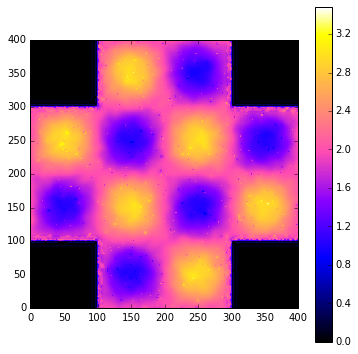

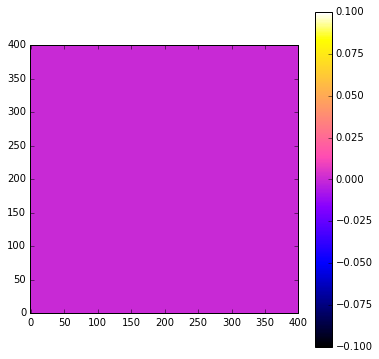

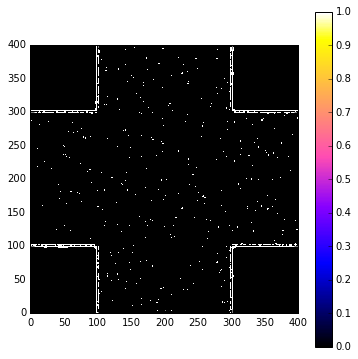

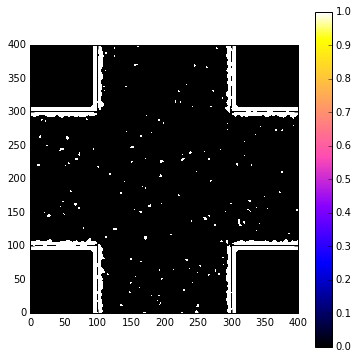

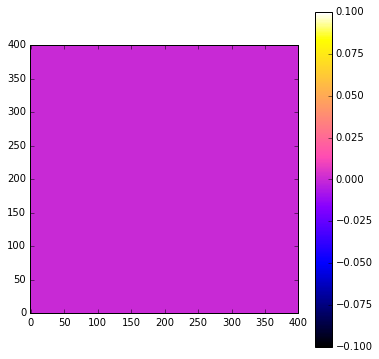

In [18]:
!mr_filter -w planes.mr -n4 znc.fits out.mr

fits_info("out.mr")
plot(read_mr_file("out.mr"))

plot(read_mr_file("planes.mr")[0])
plot(read_mr_file("planes.mr")[1])
plot(read_mr_file("planes.mr")[2])
plot(read_mr_file("planes.mr")[3])